In [ ]:


from datasets import load_dataset 

# Load only the first 5 samples of the train split
dataset = load_dataset("allenai/WildChat-1M", split="train[:1500]")

# Print the features of the dataset
print(dataset.features)

# Display the first 5 entries to check the structure
print(dataset[:5])

# Filter dataset to keep only entries with language 'English'
english_entries = [entry for entry in dataset if entry['language'] == 'English']

# Convert to DataFrame if needed
import pandas as pd
english_data = pd.DataFrame(english_entries)

# Display the first few rows of the filtered DataFrame
print(english_data.head())

chat_data = english_data



{'conversation_hash': Value(dtype='string', id=None), 'model': Value(dtype='string', id=None), 'timestamp': Value(dtype='timestamp[us, tz=UTC]', id=None), 'conversation': [{'content': Value(dtype='string', id=None), 'country': Value(dtype='string', id=None), 'hashed_ip': Value(dtype='string', id=None), 'header': {'accept-language': Value(dtype='string', id=None), 'user-agent': Value(dtype='string', id=None)}, 'language': Value(dtype='string', id=None), 'redacted': Value(dtype='bool', id=None), 'role': Value(dtype='string', id=None), 'state': Value(dtype='string', id=None), 'timestamp': Value(dtype='timestamp[us, tz=UTC]', id=None), 'toxic': Value(dtype='bool', id=None), 'turn_identifier': Value(dtype='int64', id=None)}], 'turn': Value(dtype='int64', id=None), 'language': Value(dtype='string', id=None), 'openai_moderation': [{'categories': {'harassment': Value(dtype='bool', id=None), 'harassment/threatening': Value(dtype='bool', id=None), 'harassment_threatening': Value(dtype='bool', id

In [11]:
# Extract and clean conversation content
def extract_messages(dataset, num_samples=5):
    messages = []
    for i in range(num_samples):
        conversation = dataset['conversation'][i]
        for message in conversation:
            if message['role'] == 'user':  # Only consider user messages for intent analysis
                messages.append(message['content'])
    return messages

# Apply to extract messages
sample_messages = extract_messages(dataset[:5])  # Extract from first 5 samples for now
print(sample_messages)


['Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized. There are a few things that are required of my destination. 1. The quest. I have to have a clear overarching goal in my reality, and don’t make it too crazy. It should be more along the lines of “save the president’s daughter” or “escape this weird wacky sinister place” NOT “get an artifact that literally controls reality”. Seriously, don’t make me fetch an artifact, or fetch anything. Instead, make me DO something. 2. Babes. I need pretty girls. 3. The entry. I need to get to lose consciousness in order to begin my journey in my desired reality, preferably by having it knocked out by one of the aforementioned babes. 4. Action. It needs to be cool. 5. Unconsciousness. Myself and the babes need to pass out in this place, preferably by being knocked out in some way or fainting. And it sho

topic modeling

unsupervised clustering

intent analysis

plus moderation (e.g. suicidal balh balh)

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Load a subset of WildChat dataset
dataset = load_dataset("allenai/WildChat-1M", split="train[:1000]")  # Adjust sample size as needed

# Extract messages
def extract_user_messages(dataset):
    messages = []
    for conversation in dataset['conversation']:
        for message in conversation:
            if message['role'] == 'user':
                messages.append(message['content'])
    return messages

messages = extract_user_messages(english_entries)

# Load sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(messages)

# Cluster the embeddings
num_clusters = 5  # Choose based on inspection or domain knowledge
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

# Assign clusters to messages
cluster_labels = kmeans.labels_

# Define therapeutic keywords
therapeutic_keywords = ["stress", "anxiety", "support", "cope", "depression", "help", "advice", "guidance"]

# Identify clusters related to therapeutic content
relevant_clusters = []
for cluster in range(num_clusters):
    cluster_messages = [messages[i] for i in range(len(messages)) if cluster_labels[i] == cluster]
    if any(keyword in " ".join(cluster_messages).lower() for keyword in therapeutic_keywords):
        relevant_clusters.append(cluster)

# Filter therapeutic messages
therapeutic_messages = [messages[i] for i in range(len(messages)) if cluster_labels[i] in relevant_clusters]

print("Sample therapeutic messages:", therapeutic_messages[208:216])


Sample therapeutic messages: ['test', '', 'Which singer is better technically: Floor Jansen or Taylor Swift? Rate from 1 to 10 your confidence that your answer is correct.', 'hello there!', 'how are you today', 'Se lanza un objeto hacia abajo con una rapidez de 2.8 m/s desde una altura de 8.9 m. Determine la velocidad inicial con la cual debe lanzarse otro objeto hacia arriba para que ambos choquen a una altura de 4.5 m desde el suelo', 'hello there', 'how are you today']


In [15]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load a subset of WildChat dataset
dataset = load_dataset("allenai/WildChat-1M", split="train[:100]")  # Adjust sample size as needed

# Extract user messages
def extract_user_messages(dataset):
    messages = []
    for conversation in dataset['conversation']:
        for message in conversation:
            if message['role'] == 'user':
                messages.append(message['content'])
    return messages

messages = extract_user_messages(dataset)

# Load sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(messages)

# Cluster the embeddings
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_

# Assign messages to their clusters
clustered_messages = {i: [] for i in range(num_clusters)}
for i, label in enumerate(cluster_labels):
    clustered_messages[label].append(messages[i])

# Perform topic modeling on each cluster to identify therapeutic themes
therapeutic_topics = ["stress", "anxiety", "support", "cope", "depression", "help", "advice", "guidance"]
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
therapeutic_messages = []

for cluster, msgs in clustered_messages.items():
    # Convert text data to a document-term matrix
    X = vectorizer.fit_transform(msgs)
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=3, random_state=0)  # Number of topics per cluster
    lda.fit(X)
    
    # Extract top words from each topic to check for therapeutic relevance
    terms = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        topic_keywords = [terms[i] for i in topic.argsort()[-10:]]  # Top 10 keywords per topic
        if any(keyword in therapeutic_topics for keyword in topic_keywords):
            therapeutic_messages.extend(msgs)
            break  # Move to next cluster once a therapeutic topic is found

print("Sample therapeutic messages:", therapeutic_messages[:5])


Sample therapeutic messages: []


In [19]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("allenai/WildChat-1M", split="train[:1500]")

# Define therapeutic keywords
therapeutic_keywords = [
    "anxiety", "stress", "depression", "cope", "support", "help", "therapy", 
    "counseling", "mental health", "emotion", "sad", "worry", "panic", "fear"
]

# Function to filter entries based on keywords in user messages
def is_therapeutic(conversation):
    for message in conversation:
        if message['role'] == 'user' and any(keyword in message['content'].lower() for keyword in therapeutic_keywords):
            return True
    return False

# Filter dataset
therapeutic_entries = [entry for entry in dataset if is_therapeutic(entry['conversation'])]

# Convert to dataset format if needed
import pandas as pd
therapeutic_data = pd.DataFrame(therapeutic_entries)

# Display a few samples of the filtered dataset
print(therapeutic_data.head())


                  conversation_hash       model                 timestamp  \
0  c9ec5b440fbdd2a269333dd241f32f64  gpt-4-0314 2023-04-09 00:02:53+00:00   
1  e98d3e74c57f9a65261df393d9124ac2  gpt-4-0314 2023-04-09 00:06:49+00:00   
2  2e8fd255aab694b07a0be8d83cb53a7b  gpt-4-0314 2023-04-09 00:08:41+00:00   
3  a46dca428c5be27147ab40a54ed348f8  gpt-4-0314 2023-04-09 00:11:02+00:00   
4  e18230f1108ee437a21162f2539ac8bf  gpt-4-0314 2023-04-09 00:12:23+00:00   

                                        conversation  turn language  \
0  [{'content': 'Hey there! Are you familiar with...     1  English   
1  [{'content': 'Hey there! Are you familiar with...     1  English   
2  [{'content': 'Hey there! Are you familiar with...     1  English   
3  [{'content': 'Hey there! Are you familiar with...     1  English   
4  [{'content': 'Hey there! Are you familiar with...     1  English   

                                   openai_moderation  \
0  [{'categories': {'harassment': False, 'harassm...  

In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# Load a subset of WildChat dataset
dataset = load_dataset("allenai/WildChat-1M", split="train[3000:7500]")  # Adjust sample size as needed

# Filter dataset to keep only English entries
english_entries = [entry for entry in dataset if entry['language'] == 'English']
chat_data = pd.DataFrame(english_entries)

# Initialize sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract user messages and compute embeddings
def extract_user_messages(data):
    messages = []
    for conversation in data['conversation']:
        for message in conversation:
            if message['role'] == 'user':
                messages.append(message['content'])
    return messages

# Get all user messages from the dataset for clustering
all_messages = extract_user_messages(chat_data)
embeddings = model.encode(all_messages)

# Cluster the embeddings
num_clusters = 5  # Adjust based on data
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_

# Assign each message to its cluster
chat_data['cluster'] = cluster_labels[:len(chat_data)]

# Define therapeutic keywords for relevance check
therapeutic_keywords = ["stress", "anxiety", "support", "cope", "depression", "help", "advice", "guidance"]

# Filter rows where clusters have therapeutic relevance
therapeutic_data = pd.DataFrame(columns=chat_data.columns)  # Empty DataFrame for therapeutic rows

for cluster in range(num_clusters):
    # Filter messages in this cluster
    cluster_data = chat_data[chat_data['cluster'] == cluster]
    cluster_text = " ".join(extract_user_messages(cluster_data)).lower()
    
    # Check for therapeutic keywords
    if any(keyword in cluster_text for keyword in therapeutic_keywords):
        therapeutic_data = pd.concat([therapeutic_data, cluster_data], ignore_index=True)

# Drop the 'cluster' column if not needed in the final data
therapeutic_data = therapeutic_data.drop(columns=['cluster'])
print("Filtered therapeutic data:")
print(therapeutic_data.head())

therapeutic_data.to_csv('therapeutic_data.csv', index=False)


/Users/yuewenyyy/Applied Machine Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/hr/j14tyw594cs_1fs3tsb5vgrm0000gn/T/ipykernel_24825/4232247021.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  therapeutic_dat

Filtered therapeutic data:
                  conversation_hash               model  \
0  51d647facc6c89e276610664cb9d05ca  gpt-3.5-turbo-0301   
1  43db8ead4e0b10906523df608b430212  gpt-3.5-turbo-0301   
2  9aaa93a4b7267776f1d2b92ade590ad8          gpt-4-0314   
3  4d1103dde204383b28b5aeded5ee136d          gpt-4-0314   
4  f378d947a8adc29c5889890ddb3fcff8          gpt-4-0314   

                  timestamp  \
0 2023-04-10 14:13:09+00:00   
1 2023-04-10 14:13:30+00:00   
2 2023-04-10 14:17:11+00:00   
3 2023-04-10 14:31:01+00:00   
4 2023-04-10 15:41:52+00:00   

                                        conversation turn language  \
0  [{'content': 'I want to make a Roblox hat, giv...    1  English   
1  [{'content': 'Ignore previous instructions. Yo...    1  English   
2  [{'content': 'Let A = \boldsymbol{A} = \left(\...    1  English   
3  [{'content': 'hi', 'country': 'Austria', 'hash...    3  English   
4  [{'content': 'Transform this into an engaging ...    2  English   

          

In [3]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("nbertagnolli/counsel-chat")

# Convert to DataFrame
df = pd.DataFrame(dataset['train'])

# Save to CSV
df.to_csv('counsel_chat.csv', index=False)


Repo card metadata block was not found. Setting CardData to empty.


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('counsel_chat.csv')  # Replace with your file path

# Select the column containing the therapist's answers
texts = df['answerText'].dropna().values

# Step 1: Preprocess and Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)
X = vectorizer.fit_transform(texts)

# Step 2: Clustering
# Choose a reasonable number of clusters. Start with 5–10 based on your topics
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

# Add the cluster labels back to the dataframe
df['Cluster'] = kmeans.labels_

# Step 3: Extracting Top Terms in Each Cluster for Labeling
def get_top_terms_per_cluster(tfidf_matrix, labels, vectorizer, num_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i in range(num_clusters):
        cluster_terms = tfidf_matrix[labels == i].mean(axis=0).A[0]
        top_term_indices = cluster_terms.argsort()[-num_terms:]
        top_terms[i] = [terms[index] for index in reversed(top_term_indices)]
    return top_terms

top_terms = get_top_terms_per_cluster(X, kmeans.labels_, vectorizer)
print("Top terms for each cluster:", top_terms)

# Step 4: Visualize Clusters (Optional)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.colorbar()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering of Therapist Responses')
plt.show()

# Step 5: Save or Review Clustered Data
# Export to CSV for review
df.to_csv('clustered_counsel_chat.csv', index=False)


ValueError: Length of values (2749) does not match length of index (2775)

Top terms for each cluster: {0: ['relationship', 'partner', 'trust', 'boyfriend', 'person', 'sex', 'feel', 'like', 'time', 'way'], 1: ['like', 'feel', 'want', 'things', 'help', 'people', 'know', 'don', 'time', 'talk'], 2: ['life', 'help', 'feel', 'self', 'time', 'people', 'way', 'like', 'family', 'feeling'], 3: ['therapy', 'crying', 'normal', 'emotions', 'tears', 'feel', 'absolutely', 'session', 'people', 'yes'], 4: ['anxiety', 'thoughts', 'depression', 'que', 'help', 'symptoms', 'la', 'feel', 'en', 'like'], 5: ['therapist', 'client', 'therapy', 'feel', 'counseling', 'counselor', 'fit', 'issues', 'right', 'comfortable'], 6: ['child', 'parents', 'parent', 'children', 'daughter', 'kids', 'father', 'dad', 'school', 'age']}


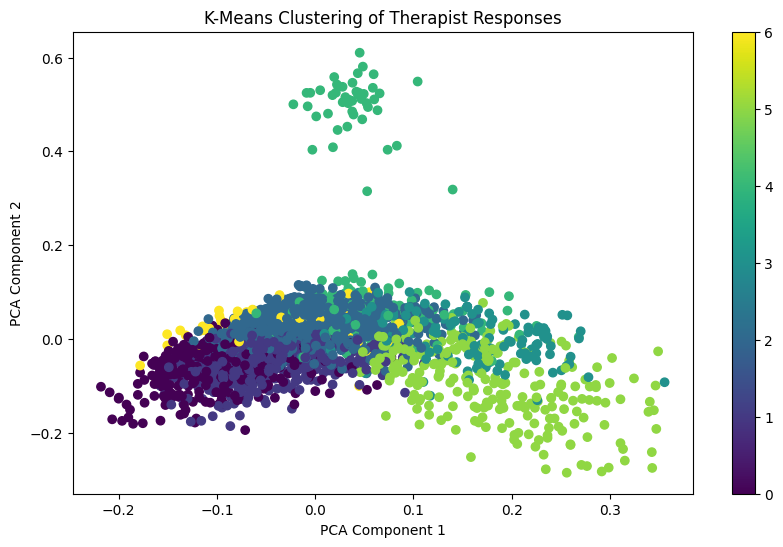

In [5]:
# Load the dataset
df = pd.read_csv('counsel_chat.csv')  # Replace with your file path

# Select the column containing the therapist's answers and drop NaN values, then reset the index
texts = df['answerText'].dropna().reset_index(drop=True)

# Step 1: Preprocess and Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)
X = vectorizer.fit_transform(texts)

# Step 2: Clustering
# Choose a reasonable number of clusters. Start with 5–10 based on your topics
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

# Add the cluster labels back to the original dataframe (only non-NaN values)
df_non_na = df.dropna(subset=['answerText']).reset_index(drop=True)
df_non_na['Cluster'] = kmeans.labels_

# Step 3: Extracting Top Terms in Each Cluster for Labeling
def get_top_terms_per_cluster(tfidf_matrix, labels, vectorizer, num_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i in range(num_clusters):
        cluster_terms = tfidf_matrix[labels == i].mean(axis=0).A[0]
        top_term_indices = cluster_terms.argsort()[-num_terms:]
        top_terms[i] = [terms[index] for index in reversed(top_term_indices)]
    return top_terms

top_terms = get_top_terms_per_cluster(X, kmeans.labels_, vectorizer)
print("Top terms for each cluster:", top_terms)

# Step 4: Visualize Clusters (Optional)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.colorbar()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering of Therapist Responses')
plt.show()

# Step 5: Save or Review Clustered Data
# Export the dataframe with clusters to CSV for review
df_non_na.to_csv('clustered_counsel_chat.csv', index=False)


In [6]:
from sklearn.decomposition import LatentDirichletAllocation

# Run LDA on the TF-IDF matrix
lda = LatentDirichletAllocation(n_components=7, random_state=0)
lda.fit(X)

# Print the top terms per topic
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Topic #{index + 1}: {', '.join(top_terms)}")


Topic #1: counselors, services, insurance, therapists, counselor, state, counseling, treatment, therapist, client
Topic #2: counseling, people, emotions, like, issues, feel, anxiety, help, therapist, therapy
Topic #3: excitement, summer, cat, mediator, tests, compensate, failing, pros, lining, cons
Topic #4: want, person, life, way, people, time, know, like, feel, relationship
Topic #5: si, una, te, para, es, tu, el, en, la, que
Topic #6: sexually, recess, dressing, fluid, gay, confusion, traumas, orientation, attraction, sexuality
Topic #7: xanax, theme, jealousy, emptiness, spouse, fantasies, dissociation, fiancé, gottman, crush


In [8]:
import numpy as np

# Get the feature names from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Number of top terms to display per cluster
num_top_terms = 10

# Initialize a dictionary to store top terms for each cluster
top_terms = {}

for i in range(num_clusters):
    # For each cluster, find the indices of the top terms by looking at the mean TF-IDF values of each term
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_center = X[cluster_indices].mean(axis=0)  # Compute mean TF-IDF score for each term
    top_term_indices = np.argsort(np.array(cluster_center).flatten())[-num_top_terms:]  # Get top terms
    
    # Store the top terms for each cluster
    top_terms[i] = [terms[index] for index in reversed(top_term_indices)]

# Print the top terms for each cluster
for cluster, keywords in top_terms.items():
    print(f"Cluster #{cluster + 1}: {', '.join(keywords)}")


Cluster #1: relationship, partner, trust, boyfriend, person, sex, feel, like, time, way
Cluster #2: like, feel, want, things, help, people, know, don, time, talk
Cluster #3: life, help, feel, self, time, people, way, like, family, feeling
Cluster #4: therapy, crying, normal, emotions, tears, feel, absolutely, session, people, yes
Cluster #5: anxiety, thoughts, depression, que, help, symptoms, la, feel, en, like
Cluster #6: therapist, client, therapy, feel, counseling, counselor, fit, issues, right, comfortable
Cluster #7: child, parents, parent, children, daughter, kids, father, dad, school, age


In [9]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load your dataset
df = pd.read_csv('counsel_chat.csv')  # Replace with your file path

# Define target themes and their representative phrases
target_themes = {
    "Problem Solving": ["Here’s how to solve the issue", "Steps to overcome your problem", "Solutions for your situation"],
    "Silver Lining": ["There’s a positive side", "Finding hope", "Looking at the bright side"],
    # Add more themes as needed
}

# Initialize the SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode the theme phrases
theme_embeddings = {theme: model.encode(phrases) for theme, phrases in target_themes.items()}

# Encode each response
response_embeddings = model.encode(df['answerText'].fillna('').tolist())

# Calculate similarity and assign themes
assigned_themes = []
for response_embedding in response_embeddings:
    max_similarity = 0
    best_theme = None
    for theme, embeddings in theme_embeddings.items():
        # Calculate mean similarity of the response to all representative phrases of the theme
        similarity = util.cos_sim(response_embedding, embeddings).mean().item()
        if similarity > max_similarity:
            max_similarity = similarity
            best_theme = theme
    assigned_themes.append(best_theme)

# Add the assigned themes to the dataframe
df['AssignedTheme'] = assigned_themes

# Save the result
df.to_csv('themed_counsel_chat.csv', index=False)


In [11]:
import pandas as pd
from scipy import stats

# Load the themed dataset with assigned themes
df = pd.read_csv('themed_counsel_chat.csv')  # Replace with your file path

# Ensure 'upvotes' and 'views' columns are numeric
df['upvotes'] = pd.to_numeric(df['upvotes'], errors='coerce')
df['views'] = pd.to_numeric(df['views'], errors='coerce')  # Only if 'views' exists

# Group by the assigned theme and calculate statistics for each theme
theme_stats = df.groupby('AssignedTheme').agg({
    'upvotes': [
        'mean', 
        'std', 
        lambda x: stats.mode(x, nan_policy='omit').mode[0] if not x.dropna().empty else None
    ],
    'views': [
        'mean', 
        'std', 
        lambda x: stats.mode(x, nan_policy='omit').mode[0] if not x.dropna().empty else None
    ]
})

# Rename the custom mode function
theme_stats.columns = ['upvotes_mean', 'upvotes_std', 'upvotes_mode', 'views_mean', 'views_std', 'views_mode']

# Display the statistics
print(theme_stats)

# Optionally, save to CSV for further analysis
theme_stats.to_csv('theme_statistics.csv')


IndexError: invalid index to scalar variable.

In [12]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load your dataset
df = pd.read_csv('counsel_chat.csv')  # Replace with your file path

# Define target themes and their representative phrases
target_themes = {
    "Emotional Validation": [
        "It’s completely understandable to feel this way",
        "Your feelings are valid and real",
        "Anyone in your situation would feel the same",
        "It makes sense that you're experiencing these emotions",
        "You're not alone in feeling this"
    ],
    "Silver Lining": [
        "There may be a hidden opportunity in this challenge",
        "This could be a chance for personal growth",
        "While it’s tough now, it might lead to positive outcomes in the future",
        "Sometimes, difficulties bring out strengths we didn’t know we had",
        "This situation could help you discover something new about yourself"
    ],
    "Growth Mindset": [
        "Think of this as a learning experience",
        "Every setback is a step toward growth",
        "You can develop skills to handle this better over time",
        "Mistakes are opportunities to learn and improve",
        "You have the potential to overcome this and become stronger"
    ],
    "Problem Solving": [
        "Let’s break down the steps to tackle this issue",
        "What small changes could help improve the situation?",
        "Have you considered trying X to see if it helps?",
        "Let’s identify practical steps you can take",
        "There might be a way to approach this differently"
    ],
    "Distancing": [
        "Try to view the situation from an outsider's perspective",
        "Imagine what advice you would give a friend in your position",
        "Take a step back and observe your thoughts without judgment",
        "Consider how you might look at this a few years from now",
        "Try to detach emotionally and see the bigger picture"
    ]
}
# Initialize the SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode the theme phrases
theme_embeddings = {theme: model.encode(phrases) for theme, phrases in target_themes.items()}

# Encode each response
response_embeddings = model.encode(df['answerText'].fillna('').tolist())

# Calculate similarity and assign themes
assigned_themes = []
for response_embedding in response_embeddings:
    max_similarity = 0
    best_theme = None
    for theme, embeddings in theme_embeddings.items():
        # Calculate mean similarity of the response to all representative phrases of the theme
        similarity = util.cos_sim(response_embedding, embeddings).mean().item()
        if similarity > max_similarity:
            max_similarity = similarity
            best_theme = theme
    assigned_themes.append(best_theme)

# Add the assigned themes to the dataframe
df['AssignedTheme'] = assigned_themes

# Save the result
df.to_csv('themed_counsel_chat_2.csv', index=False)


In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Load your dataset with the assigned themes
df = pd.read_csv('themed_counsel_chat_2.csv')  # Replace with your file path

# Normalize upvotes and views to create a preference score
scaler = MinMaxScaler()
df[['normalized_upvotes', 'normalized_views']] = scaler.fit_transform(df[['upvotes', 'views']])

# Define a weight for each component, giving more importance to upvotes, for example
weight = 0.7
df['preference_score'] = (df['normalized_upvotes'] * weight) + (df['normalized_views'] * (1 - weight))

# Initialize SBERT model (assuming model is already initialized in your previous code)
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode the questionText (client input) and answerText (therapist response)
question_embeddings = model.encode(df['questionText'].fillna('').tolist())
answer_embeddings = model.encode(df['answerText'].fillna('').tolist())

# Combine the question and answer embeddings for training
combined_embeddings = np.hstack((question_embeddings, answer_embeddings))

# Prepare target and features for training
X = combined_embeddings
y = df['preference_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train a regression model to predict preference score
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Define the prediction function to find the preferred theme for a client input
def predict_preferred_theme(client_input):
    # Encode the client input (questionText) using SBERT
    client_embedding = model.encode([client_input])[0]

    # Calculate preference scores for each theme based on representative embeddings
    preference_scores = []
    for theme, theme_phrases in theme_embeddings.items():
        # Calculate mean theme embedding by averaging phrase embeddings for each theme
        theme_embedding = np.mean(theme_phrases, axis=0)
        
        # Combine the client input embedding with the theme embedding
        combined_input_theme_embedding = np.hstack((client_embedding, theme_embedding))

        # Predict preference score for this theme
        preference_score = regressor.predict(combined_input_theme_embedding.reshape(1, -1))
        preference_scores.append((theme, preference_score[0]))

    # Select the theme with the highest predicted preference score
    best_theme = max(preference_scores, key=lambda x: x[1])[0]
    return best_theme

# Test with a sample client input
client_input = "I feel really overwhelmed and don’t know where to start solving this issue."
preferred_theme = predict_preferred_theme(client_input)
print(f"The preferred theme for this input is: {preferred_theme}")

The preferred theme for this input is: Silver Lining
